## Making your own performance metric

In [1]:
# import libraries

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier

In [2]:
# if you want more information about the dataset for this demo:

# scikit-learn dataset
# https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

# dataset information: UCI Machine Learning Repository
# https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
    
# in short, classification problem, trying to predict whether the tumor
# is malignant or benign

# load dataset
load_breast_cancer(return_X_y=False)

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [3]:
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

## Confusion matrix

We will use the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
) function from sklearn to return the false positive, false negatives, true positives and true negatives, to construct the false negative rate.


TN | FP

FN | TP

## False Negative Rate

Because it is a dangerous disease, I want to minimize the number of false negatives cases (the false negative rate). That is, I want to minimize the number of cases where the tumor in a patient is malign (1) and it is wrongly classified as benign (0). This way, we can offer treatment to as many patients as possible.

Because the **False Negative Rate** is not a metric available in sklearn, we need to create a function ourselves.

We will use the [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function from sklearn:

In [5]:
# function returns the FNR given probabilities and the 
# grand truth

def fnr(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0,1]).ravel()
    
    FNR = fn/(fn + tp)
    
    return FNR

In [6]:
fnr_score = make_scorer(fnr,
                        greater_is_better=False, # smaller is better
                        needs_proba=False) # when you make the scoring based on the class 
                                            # and not on the custom probabilities
                                        # this case, it automatically chooses the class is probability is > 0.5

In [7]:
# set up the estimator
rf = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0,n_jobs=2)

In [8]:
# perform GridSearchCV

# set up param_grid

param_grid = dict(
    n_estimators = [10,50, 100, 200, 300],
    max_depth = [1,2,3,4]
)

# set the GridSearch

clf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=fnr_score, n_jobs=2, cv = 3)

search = clf.fit(X,y)

In [9]:
# best params
search.best_params_

{'max_depth': 4, 'n_estimators': 10}

In [10]:
# get the cv results
search.cv_results_

{'mean_fit_time': array([0.04927953, 0.07199891, 0.134667  , 0.26466608, 0.43099928,
        0.02533182, 0.07399933, 0.1616648 , 0.27699884, 0.42100048,
        0.01766531, 0.06933006, 0.15199844, 0.27666839, 0.42333245,
        0.01933352, 0.08633272, 0.14199813, 0.27699971, 0.40899889]),
 'std_fit_time': array([0.01858125, 0.00081751, 0.0018852 , 0.01543667, 0.00941631,
        0.0018834 , 0.00852278, 0.01438485, 0.01801794, 0.01512005,
        0.0004725 , 0.00046811, 0.01444429, 0.01302486, 0.00679811,
        0.0004721 , 0.01020955, 0.00848208, 0.0035585 , 0.00244892]),
 'mean_score_time': array([0.01059953, 0.01833256, 0.02733429, 0.04533339, 0.06799952,
        0.00700029, 0.01466719, 0.02566576, 0.04733475, 0.06499982,
        0.00633438, 0.01433372, 0.02666879, 0.04766552, 0.06766701,
        0.00633415, 0.01633358, 0.02466695, 0.04499944, 0.0635074 ]),
 'std_score_time': array([4.25964149e-04, 4.69291200e-04, 4.70302724e-04, 2.49291967e-03,
        4.89901375e-03, 8.16441494e-

In [17]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
results

,params,mean_test_score,std_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",-0.169416,0.074960
1,"{'max_depth': 1, 'n_estimators': 50}",-0.174111,0.081148
2,"{'max_depth': 1, 'n_estimators': 100}",-0.178672,0.103397
3,"{'max_depth': 1, 'n_estimators': 200}",-0.178672,0.103397
4,"{'max_depth': 1, 'n_estimators': 300}",-0.178672,0.103397
5,"{'max_depth': 2, 'n_estimators': 10}",-0.136419,0.069010
6,"{'max_depth': 2, 'n_estimators': 50}",-0.089403,0.047681
7,"{'max_depth': 2, 'n_estimators': 100}",-0.103555,0.040075
8,"{'max_depth': 2, 'n_estimators': 200}",-0.103555,0.040075
9,"{'max_depth': 2, 'n_estimators': 300}",-0.103555,0.040075


In [19]:
results.sort_values(by='mean_test_score', ascending=False, inplace = True)
results

,params,mean_test_score,std_test_score
15,"{'max_depth': 4, 'n_estimators': 10}",-0.079946,0.040215
19,"{'max_depth': 4, 'n_estimators': 300}",-0.084708,0.034254
18,"{'max_depth': 4, 'n_estimators': 200}",-0.084708,0.034254
17,"{'max_depth': 4, 'n_estimators': 100}",-0.084708,0.034254
16,"{'max_depth': 4, 'n_estimators': 50}",-0.084708,0.034254
12,"{'max_depth': 3, 'n_estimators': 100}",-0.084708,0.034254
6,"{'max_depth': 2, 'n_estimators': 50}",-0.089403,0.047681
13,"{'max_depth': 3, 'n_estimators': 200}",-0.089470,0.028637
11,"{'max_depth': 3, 'n_estimators': 50}",-0.089470,0.028637
14,"{'max_depth': 3, 'n_estimators': 300}",-0.094165,0.034847


In [22]:
results.reset_index(drop=True, inplace = True)
results

,params,mean_test_score,std_test_score
0,"{'max_depth': 4, 'n_estimators': 10}",-0.079946,0.040215
1,"{'max_depth': 4, 'n_estimators': 300}",-0.084708,0.034254
2,"{'max_depth': 4, 'n_estimators': 200}",-0.084708,0.034254
3,"{'max_depth': 4, 'n_estimators': 100}",-0.084708,0.034254
4,"{'max_depth': 4, 'n_estimators': 50}",-0.084708,0.034254
5,"{'max_depth': 3, 'n_estimators': 100}",-0.084708,0.034254
6,"{'max_depth': 2, 'n_estimators': 50}",-0.089403,0.047681
7,"{'max_depth': 3, 'n_estimators': 200}",-0.089470,0.028637
8,"{'max_depth': 3, 'n_estimators': 50}",-0.089470,0.028637
9,"{'max_depth': 3, 'n_estimators': 300}",-0.094165,0.034847


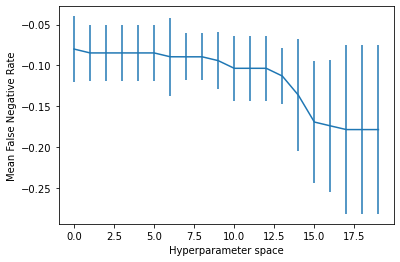

In [27]:
#plotting the mean test score
results['mean_test_score'].plot(yerr = (results['std_test_score'],results['std_test_score']))
plt.ylabel('Mean False Negative Rate')
plt.xlabel('Hyperparameter space')
plt.show();

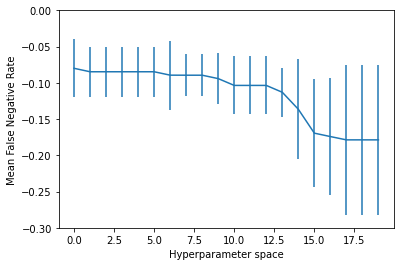

In [29]:
#plotting the mean test score
results['mean_test_score'].plot(yerr = [results['std_test_score'],results['std_test_score']], subplots=True)
plt.ylim(-0.3, 0)
plt.ylabel('Mean False Negative Rate')
plt.xlabel('Hyperparameter space')
plt.show();

- Above case, we determined the scores based on the class prediction and that by default, the probability chosen is 0.5

## Scoring Function that needs a probability

In [5]:
def fnr_prob(y_true, y_pred):
    
    # if the probability given by y_pred is 0.37, then we are assinging it to Class 1 i.e to Malign 
    y_pred_class = np.where(y_pred > 0.37, 1,0) 
        
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred_class, labels=[0,1]).ravel()
    
    FNR = fn/(fn + tp)
    
    return FNR    

In [6]:
# the rest is the same

fnr_Score = make_scorer(fnr_prob,
                        greater_is_better=False,
                        needs_proba=True  # True as we need the probability to define the class
                       )

In [7]:
# set up the estimator
rf_model = RandomForestClassifier(n_estimators=100, max_depth=1, n_jobs=2, random_state=0)

In [9]:
# perform GridSearchCV

# set up param_grid

param_grid = dict(
    n_estimators = [10,50, 100, 200, 300],
    max_depth = [1,2,3,4]
)

# set the GridSearch

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=fnr_Score, n_jobs=2, cv = 3)

search = clf.fit(X,y)

In [10]:
search.best_params_

{'max_depth': 3, 'n_estimators': 10}

In [11]:
search.best_score_

-0.037625754527162984

In [12]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
results

,params,mean_test_score,std_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",-0.065862,0.026368
1,"{'max_depth': 1, 'n_estimators': 50}",-0.075184,0.051777
2,"{'max_depth': 1, 'n_estimators': 100}",-0.098659,0.091216
3,"{'max_depth': 1, 'n_estimators': 200}",-0.103353,0.097745
4,"{'max_depth': 1, 'n_estimators': 300}",-0.103353,0.097745
5,"{'max_depth': 2, 'n_estimators': 10}",-0.079879,0.057806
6,"{'max_depth': 2, 'n_estimators': 50}",-0.047015,0.028865
7,"{'max_depth': 2, 'n_estimators': 100}",-0.051710,0.035061
8,"{'max_depth': 2, 'n_estimators': 200}",-0.056405,0.041395
9,"{'max_depth': 2, 'n_estimators': 300}",-0.056405,0.041395


In [13]:
results.sort_values(by='mean_test_score', ascending=False, inplace = True)
results

,params,mean_test_score,std_test_score
10,"{'max_depth': 3, 'n_estimators': 10}",-0.037626,0.017477
15,"{'max_depth': 4, 'n_estimators': 10}",-0.037626,0.017477
18,"{'max_depth': 4, 'n_estimators': 200}",-0.042321,0.022918
17,"{'max_depth': 4, 'n_estimators': 100}",-0.042321,0.022918
19,"{'max_depth': 4, 'n_estimators': 300}",-0.042321,0.022918
6,"{'max_depth': 2, 'n_estimators': 50}",-0.047015,0.028865
11,"{'max_depth': 3, 'n_estimators': 50}",-0.047015,0.028865
16,"{'max_depth': 4, 'n_estimators': 50}",-0.047015,0.028865
7,"{'max_depth': 2, 'n_estimators': 100}",-0.051710,0.035061
12,"{'max_depth': 3, 'n_estimators': 100}",-0.051710,0.035061


In [14]:
results.reset_index(drop=True, inplace =True)

<AxesSubplot:>

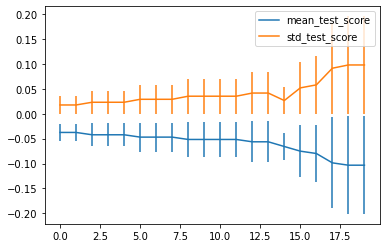

In [15]:
results.plot(yerr=(results['std_test_score'],results['std_test_score']))

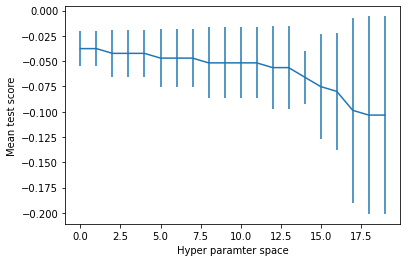

In [16]:
results['mean_test_score'].plot(yerr=(results['std_test_score'],results['std_test_score']))
plt.ylabel('Mean test score')
plt.xlabel('Hyper paramter space')
plt.show();

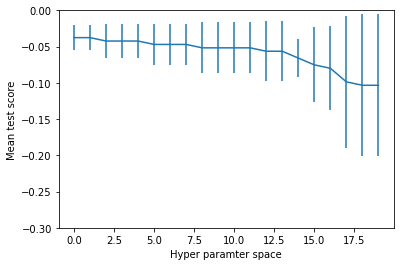

In [17]:
results['mean_test_score'].plot(yerr=(results['std_test_score'],results['std_test_score']))
plt.ylim(-0.30, 0)
plt.ylabel('Mean test score')
plt.xlabel('Hyper paramter space')
plt.show();

Now that we modified the scoring function using a probability threshold that better represents the distribution of the class in the data, we are able to minimize fuurther the FNR.